In [1]:
!nvidia-smi

Thu Oct 22 17:20:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 450.66       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 8000     On   | 00000000:19:00.0 Off |                  Off |
| 34%   37C    P8    32W / 260W |   1536MiB / 48601MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 8000     On   | 00000000:1A:00.0 Off |                  Off |
| 33%   

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [3]:
import os.path as osp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import torch
import torch.nn as nn
import datetime
import time
%matplotlib inline
from IPython.core.debugger import set_trace
from torch_geometric.data import Data, Dataset, InMemoryDataset, DataLoader
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, GRU, BatchNorm1d, LeakyReLU, LayerNorm
from torch_geometric.nn import GCNConv, SplineConv, NNConv, DeepGCNLayer, GENConv
import pyvista as pv
from threading import Thread
import vtk
from IPython.display import HTML, display
from pyvirtualdisplay import Display
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
import seaborn as sns
np.random.seed(0)
torch.manual_seed(0)
pv.set_plot_theme("document")
sns.set(color_codes=True, font_scale=1)

In [4]:
class AdditiveThermalDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None, normalize=True):
        self.seq_len = 100
        self.sample_per_simulation = 100
        self.simulation_ids = [x.stem for x in Path('/home/mmv664/Documents/Graph_modeling/AutoGAMMA/2_simulation_results').iterdir() if x.is_dir()]
        self.normalize = normalize
        if normalize:
            self.stats = torch.load("/home/mmv664/Documents/Graph_modeling/Graph_AM_Modeling/processed/stats")
        super(AdditiveThermalDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ['am_graph.simul0.data0']

    def download(self):
        pass
    
    def process(self):
        print('wrong place!')
            
    def len(self):
        return self.sample_per_simulation * len(self.simulation_ids) * (self.seq_len-1)

    def get(self, idx):
        i = idx//(self.sample_per_simulation * (self.seq_len-1))
        j = (idx%(self.sample_per_simulation * (self.seq_len-1)))//(self.seq_len-1)
        k = (idx%(self.sample_per_simulation * (self.seq_len-1)))%(self.seq_len-1)
        constant_data = torch.load(osp.join(self.processed_dir, 'am_graph.simul{}.const'.format(i)))
        data = torch.load(osp.join(self.processed_dir, 'am_graph.simul{}.data{}'.format(i,j)))
        smoothed = self.smooth(data['y'])
        data_x = data['x'][k, :, :]
        data_x_p1 = data['x'][k + 1, :, :]
        data_e = constant_data['edge_attr']
        data_xt = smoothed[k, :, :]
        data_y = smoothed[k + 1, :, :]
#         data_xt = data['y'][k, :, :]
#         data_y = data['y'][k + 1, :, :]
        if self.normalize:
            # normalize boundary feature to the range of 0-1
            data_x[:,1] = (data_x[:,1] - self.stats[1,2]) / (self.stats[1,3] - self.stats[1,2])
            # normalize laser feature to mean of zeros and std of 1
#             data_x[:,2] = (data_x[:,2] - self.stats[2,2]) / (self.stats[2,3] - self.stats[2,2])
            # nomalize edge feature to mean of zero and std of 1
            data_e = 1.0/data_e**0.5
            # normalize temperature to the range of 0-1
#             data_xt = (data_xt - self.stats[3,2]) / (self.stats[3,3] - self.stats[3,2])
#             data_y = (data_y - self.stats[3,2]) / (self.stats[3,3] - self.stats[3,2])
#             data_xt = (data_xt.clamp(300, 5000) - 300) / 4700
#             data_y = (data_y.clamp(300, 5000) - 300) / 4700
            data_xt = (data_xt - 300) / 4700
            data_y = (data_y - 300) / 4700
            
        return Data(
#                     x=torch.cat((data_xt, data_x), 1), 
                    x=torch.cat((data_xt, data_x, data_x_p1[:,:1]), 1), 
                    y=data_y, 
                    pos=constant_data['pos'], 
                    edge_index=constant_data['edge_index'],
                    edge_attr = data_e,
                    birth_element=data['birth_element'][k + 1,:],
                    elements=constant_data['elements']
                   )
    
    def smooth(self, data, base_temp = 5000):
        added = (data - base_temp).clamp(min = 0) / 10
        final = data.clamp(max = base_temp) + added
        return final

In [5]:
dataset = AdditiveThermalDataset('/home/mmv664/Documents/Graph_modeling/Graph_AM_Modeling', normalize=True)

In [21]:
points

array([[ 15.648198,  -6.370952,   0.      ],
       [  9.608572,  -6.370952,   0.      ],
       [  9.608572,  -0.946893,   0.      ],
       ...,
       [ -7.149238,  11.127164, -15.      ],
       [ -6.933701,  13.554408, -15.      ],
       [ -6.17553 ,  13.181404, -15.      ]], dtype=float32)

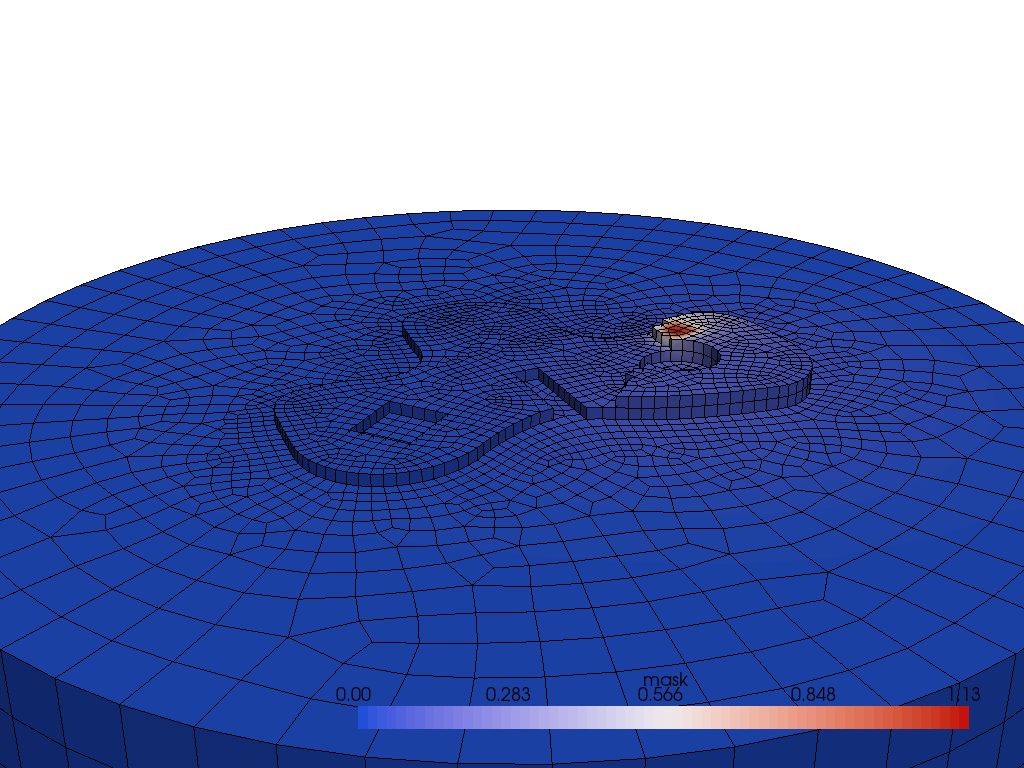

In [14]:
camera_position = [(100, 50, 50),(0.0, 0.0, 0.0), (0.0, 0.0, 1.0)]
display = Display(visible=0)
_ = display.start()
p = pv.Plotter()

test_id = np.random.randint(0,len(dataset))
data = dataset[test_id]
output = data.y
    
active_elements = [element.tolist() for element, birth_time in zip(data['elements'], data['birth_element']) if birth_time > 0.5]
active_cells = np.array([item for sublist in active_elements for item in [8] + sublist])
active_cell_type = np.array([vtk.VTK_HEXAHEDRON] * len(active_elements))
points = np.array(data['pos'])
active_grid = pv.UnstructuredGrid(active_cells, active_cell_type, points)
active_grid.point_arrays['mask'] = np.array(output)
p.camera_position = camera_position
p.add_mesh(active_grid, show_edges=True, scalars='mask',cmap="coolwarm")
p.show()

In [6]:
test_simulations = 5
train_samples = 10000
test_start_index = (len(dataset.simulation_ids) - test_simulations)* dataset.sample_per_simulation * (dataset.seq_len-1)
train_dataset = dataset[:test_start_index]
train_dataset = train_dataset.shuffle()
train_dataset = train_dataset[:train_samples]
test_dataset = dataset[test_start_index:]
len(train_dataset), len(test_dataset)

(10000, 49500)

In [7]:
class DeeperGCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_layers):
        super(DeeperGCN, self).__init__()

        self.node_encoder = Linear(5, hidden_channels)
        self.edge_encoder = Linear(1, hidden_channels)

        self.layers = torch.nn.ModuleList()
        for i in range(1, num_layers + 1):
            conv = GENConv(hidden_channels, hidden_channels, aggr='softmax',
                           t=1.0, learn_t=True, num_layers=2, norm='layer')
            norm = LayerNorm(hidden_channels, elementwise_affine=True)
            act = LeakyReLU(inplace=True)
            layer = DeepGCNLayer(conv, norm, act, block='res+')
            self.layers.append(layer)
    
        self.conv2 = GENConv(hidden_channels, 1, aggr='softmax',
                           t=1.0, learn_t=True, num_layers=2, norm='layer')

    def forward(self, data):
        x, y, edge_index, edge_attr = data.x, data.y, data.edge_index, data.edge_attr
        out = self.node_encoder(x)
        edge_attr = self.edge_encoder(edge_attr.unsqueeze(1))
        out = self.layers[0].conv(out, edge_index, edge_attr)
        for layer in self.layers[1:]:
            out = layer(out, edge_index, edge_attr) 
        out = self.conv2(out, edge_index, edge_attr) + x[:, :1]
        
        return out

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

path_mask = '../Models/final_masked.pt'
model_mask = DeeperGCN(hidden_channels=64, num_layers=6).to(device)
model_mask.load_state_dict(torch.load(path_mask))
model_mask.eval()

path_no_mask = '../Models/final_no_mask.pt'
model_no_mask = DeeperGCN(hidden_channels=64, num_layers=6).to(device)
model_no_mask.load_state_dict(torch.load(path_no_mask))
model_no_mask.eval()

DeeperGCN(
  (node_encoder): Linear(in_features=5, out_features=64, bias=True)
  (edge_encoder): Linear(in_features=1, out_features=64, bias=True)
  (layers): ModuleList(
    (0): DeepGCNLayer(block=res+)
    (1): DeepGCNLayer(block=res+)
    (2): DeepGCNLayer(block=res+)
    (3): DeepGCNLayer(block=res+)
    (4): DeepGCNLayer(block=res+)
    (5): DeepGCNLayer(block=res+)
  )
  (conv2): GENConv(64, 1, aggr=softmax)
)

### Training losses

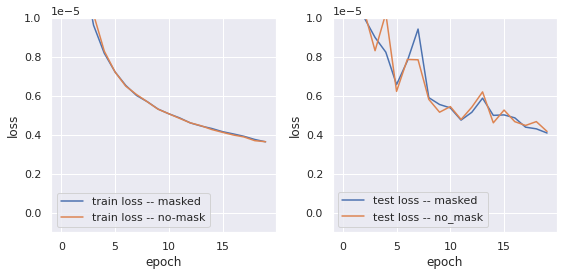

In [25]:
his_mask = torch.load('../Models/final_masked.txt')
his_no_mask = torch.load('../Models/final_no_mask.txt')

fig, ax = plt.subplots(1, 2, figsize = (8,4))
ax[0].plot(range(his_mask.shape[0]), his_mask[:,0], label='train loss -- masked')
ax[0].plot(range(his_no_mask.shape[0]), his_no_mask[:,1], label='train loss -- no-mask')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(loc = 'lower left')
ax[0].set_ylim([-1e-6,1e-5])

ax[1].plot(range(his_mask.shape[0]), his_mask[:,1], label='test loss -- masked')
ax[1].plot(range(his_no_mask.shape[0]), his_no_mask[:,3], label='test loss -- no_mask')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(loc = 'lower left')
ax[1].set_ylim([-1e-6,1e-5])
plt.tight_layout()
plt.show()

### Single time-step prediction

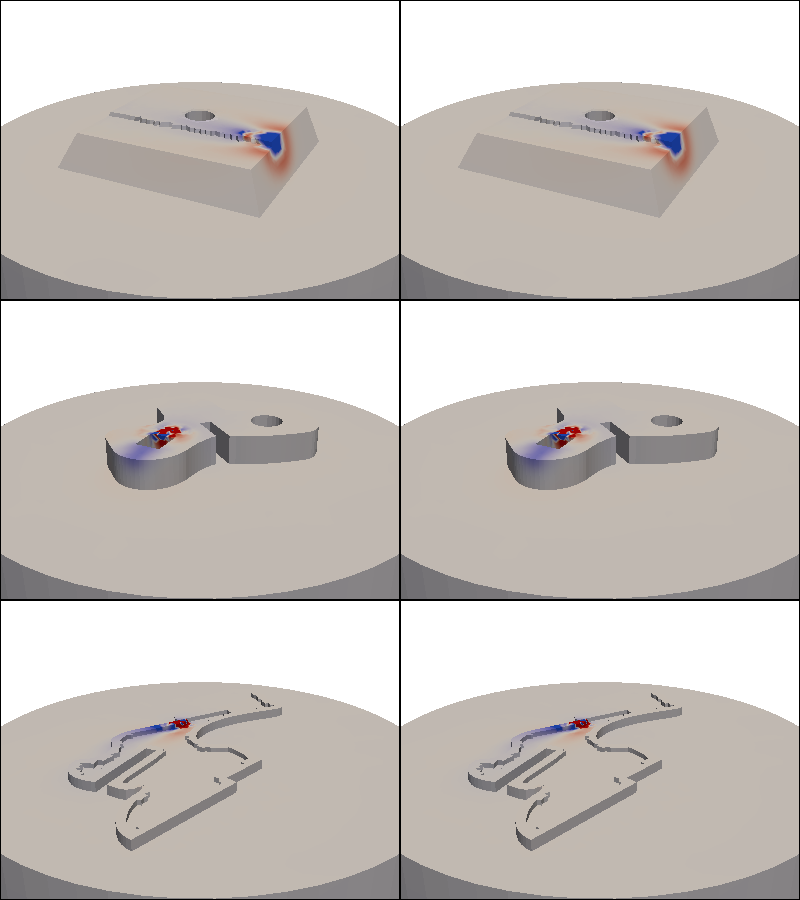

In [70]:
n_test = 3
camera_position = [(100, 50, 50),(0.0, 0.0, 0.0), (0.0, 0.0, 1.0)]
range_ = [-0.01, 0.01]
display = Display(visible=0)
_ = display.start()
p = pv.Plotter(shape=(n_test, 2), window_size=([800, n_test* 300]),)

for i in range(n_test):
    test_id = np.random.randint(0,len(test_dataset))
    data = test_dataset[test_id]
    data = data.to(device)
    with torch.no_grad():
        pred_mask =  model_mask(data).to("cpu")
        pred_no_mask =  model_no_mask(data).to("cpu")
    data = data.to("cpu")
    output_mask = np.array(data.y-pred_mask)
    output_no_mask = np.array(data.y-pred_no_mask)
    
    active_elements = [element.tolist() for element, birth_time in zip(data['elements'], data['birth_element']) if birth_time > 0.5]
    active_cells = np.array([item for sublist in active_elements for item in [8] + sublist])
    active_cell_type = np.array([vtk.VTK_HEXAHEDRON] * len(active_elements))
    points = np.array(data['pos'])
    active_grid = pv.UnstructuredGrid(active_cells, active_cell_type, points)
    active_grid.point_arrays['mask'] = np.array(output_mask)
    active_grid.point_arrays['no_mask'] = np.array(output_no_mask)
    
    p.subplot(i,0)
    p.camera_position = camera_position
    p.add_mesh(active_grid, show_edges=show_edges, scalars='mask',cmap="coolwarm",clim = range_, show_scalar_bar=False)
    
    p.subplot(i,1)
    p.camera_position = camera_position
    p.add_mesh(active_grid, show_edges=show_edges, scalars='no_mask',cmap="coolwarm",clim = range_, show_scalar_bar=False)
    
p.show()

### Recursive prediction

In [154]:
sample_num = 3
predictions_mask = []
predictions_no_mask = []
targets = []
births = []
for time_step in range(99):
    data = dataset[sample_num*99 + time_step]
    if time_step != 0:
        data.x = torch.cat((pred_mask,data.x[:,1:]), 1)
    target = data.y
    data = data.to(device)
    with torch.no_grad():
        pred_mask =  model_mask(data).to("cpu")
    mask = data.x[:,1].reshape(-1,1)
    pred_mask = pred_mask * mask.to("cpu")
    predictions_mask.append(pred_mask)
    targets.append(target)
    births.append(data.x[:,1].to("cpu"))
    
for time_step in range(99):
    data = dataset[sample_num*99 + time_step]
    if time_step != 0:
        data.x = torch.cat((pred_no_mask,data.x[:,1:]), 1)
    data = data.to(device)
    with torch.no_grad():
        pred_no_mask =  model_no_mask(data).to("cpu")
    mask = data.x[:,1].reshape(-1,1)
    pred_no_mask = pred_no_mask * mask.to("cpu")
    predictions_no_mask.append(pred_no_mask)
    
new_birth = births[-1] - birth[0]
predictions_mask = torch.stack(predictions_mask)[:,:,0] * 4700 + 300
predictions_no_mask = torch.stack(predictions_no_mask)[:,:,0] * 4700 + 300
targets = torch.stack(targets)[:,:,0] * 4700 + 300
active_count = (torch.stack(births)> 0).sum(1)
error_mask = torch.sqrt(torch.sum(torch.square(predictions_mask - targets), dim = 1) / active_count)
error_no_mask = torch.sqrt(torch.sum(torch.square(predictions_no_mask - targets), dim = 1) / active_count)

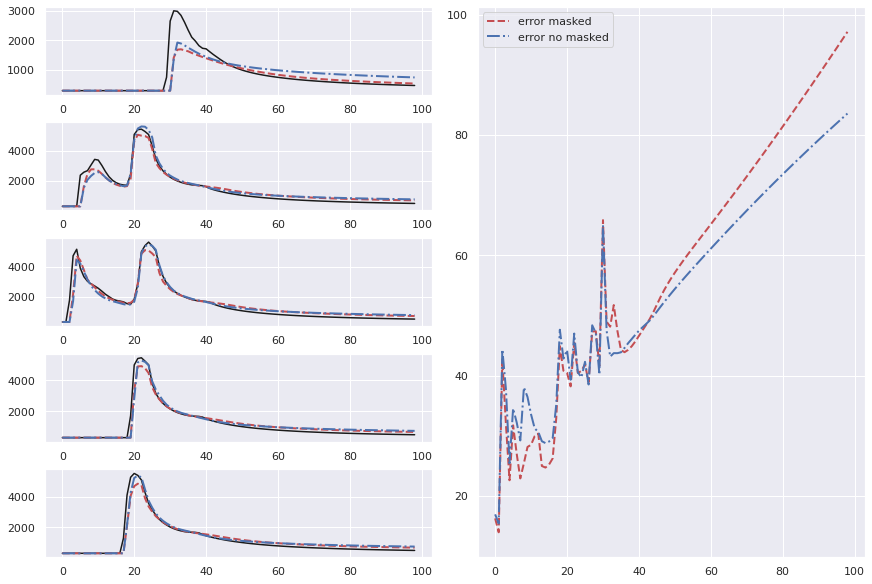

In [157]:
inds = np.random.choice(np.where(new_birth.numpy()>0)[0], 5)

samples = len(inds)

fig = plt.figure(constrained_layout=True, figsize=(12,8))
clrs = sns.color_palette(n_colors=samples)
gs = fig.add_gridspec(samples, 2)

x_range = list(range(99))
ax = fig.add_subplot(gs[:, 1])
ax.plot(x_range, error_mask, '--', c='r', linewidth=2, label='error masked')
ax.plot(x_range, error_no_mask, '-.', c='b', linewidth=2, label='error no masked')
ax.legend()
for i in range(samples):
    ax = fig.add_subplot(gs[i, 0])
    ax.plot(x_range, targets[:, inds[i]], c='k', label = 'target')
    ax.plot(x_range, predictions_mask[:, inds[i]], '--', c='r', linewidth=2, label = 'prediction with mask')
    ax.plot(x_range, predictions_no_mask[:, inds[i]], '-.', c='b', linewidth=2, label = 'prediction without mask')
plt.show()

### Overall recursive prediciton

In [169]:
errors_mask = []
errors_no_mask = []
for sample_num in range(4000, 4500):
    predictions_mask = []
    predictions_no_mask = []
    targets = []
    births = []
    for time_step in range(99):
        data = dataset[sample_num*99 + time_step]
        if time_step != 0:
            data.x = torch.cat((pred_mask,data.x[:,1:]), 1)
        target = data.y
        data = data.to(device)
        with torch.no_grad():
            pred_mask =  model_mask(data).to("cpu")
        mask = data.x[:,1].reshape(-1,1)
        pred_mask = pred_mask * mask.to("cpu")
        predictions_mask.append(pred_mask)
        targets.append(target)
        births.append(data.x[:,1].to("cpu"))

    
    for time_step in range(99):
        data = dataset[sample_num*99 + time_step]
        if time_step != 0:
            data.x = torch.cat((pred_no_mask,data.x[:,1:]), 1)
        data = data.to(device)
        with torch.no_grad():
            pred_no_mask =  model_no_mask(data).to("cpu")
        mask = data.x[:,1].reshape(-1,1)
        pred_no_mask = pred_no_mask * mask.to("cpu")
        predictions_no_mask.append(pred_no_mask)
        
    predictions_mask = torch.stack(predictions_mask)[:,:,0] * 4700 + 300
    predictions_no_mask = torch.stack(predictions_no_mask)[:,:,0] * 4700 + 300
    targets = torch.stack(targets)[:,:,0] * 4700 + 300
    
    active_count = (torch.stack(births)> 0).sum(1)
    errors_mask.append(torch.sqrt(torch.sum(torch.square(predictions_mask - targets), dim = 1) / active_count))
    errors_no_mask.append(torch.sqrt(torch.sum(torch.square(predictions_no_mask - targets), dim = 1) / active_count))
    
errors_mask = torch.stack(errors_mask).mean(0)
errors_no_mask = torch.stack(errors_no_mask).mean(0)

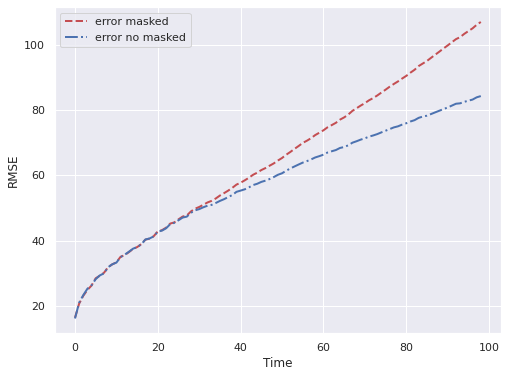

In [172]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
x_range = list(range(99))
ax.plot(x_range, errors_mask, '--', c='r', linewidth=2, label='error masked')
ax.plot(x_range, errors_no_mask, '-.', c='b', linewidth=2, label='error no masked')
ax.set_ylabel('RMSE')
ax.set_xlabel('Time')
ax.legend()
plt.show()